#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


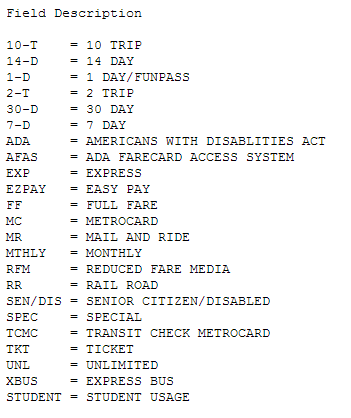

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as pl
import statsmodels.api as sm
import seaborn as sns

import os
import json
s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'));
pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/ArnoAmabile/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
mta = np.load('MTA_Fare.npy')
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']

In [5]:
stations = range(0,600)

In [6]:
panel = pd.Panel(mta, items=stations, minor_axis=pd.date_range('05/21/2010', periods=194, freq='W-FRI'),
                 major_axis=ridetype).swapaxes(axis1='items', axis2='major').to_frame().reset_index('major')
panel.columns = ['Station'] + ridetype
#pd.to_datetime(panel.Week)
#panel.set_index(panel.Week)
panel['Total'] = panel.loc[:,ridetype].sum(axis=1)
panel[panel == -1] = np.nan

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

In [7]:
weekly = panel.groupby(panel.index).sum()

29778001.6082 2991755.01883
[38753266.66473153, 20802736.55176331]


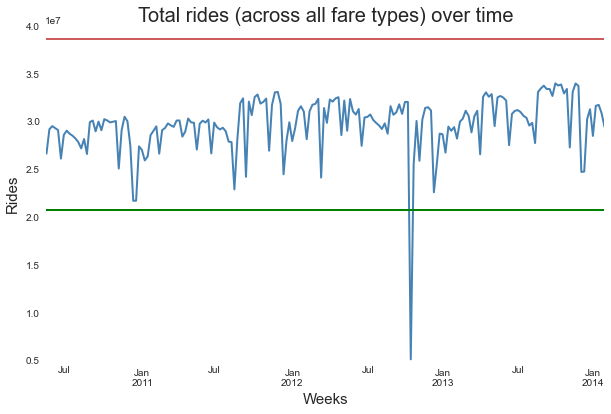

In [8]:
print weekly['Total'].mean(), weekly['Total'].std()
thresholds = [weekly['Total'].mean() + 3*weekly['Total'].std(), 
              weekly['Total'].mean() - 3*weekly['Total'].std()]
print thresholds

ax = weekly.Total.plot(figsize=(10,6))
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
ax.set_title('Total rides (across all fare types) over time', fontsize=20)
ax.set_xlabel('Weeks', fontsize=15)
ax.set_ylabel('Rides', fontsize=15);

**Fig. 1** Time series of total MTA rides across all ride types, from May 2010 to February 2014. The upper and lower boundaries are respectively three standard deviations above and below the mean.

In [9]:
print 'An event happened on the {}'.format(weekly.loc[weekly.Total < thresholds[1]].index[0])

An event happened on the 2012-10-19 00:00:00


Very surprisingly: https://en.wikipedia.org/wiki/Hurricane_Sandy

29778001.6082 2991755.01883
[38753266.66473153, 20802736.55176331]
2010-05-21 00:00:00


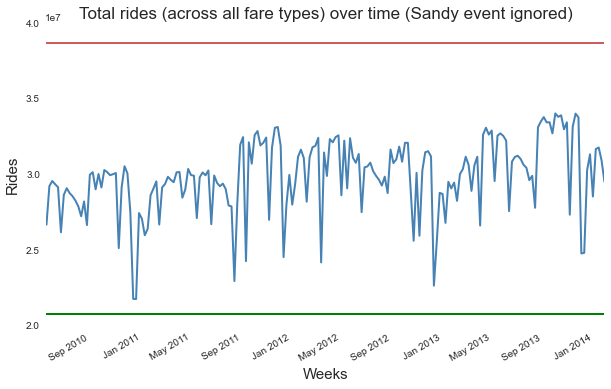

In [10]:
"""
for rtype in ridetype + ['Total']:
    thresholds = [weekly[rtype].mean() + 3*weekly[rtype].std(),
                 weekly[rtype].mean() - 3*weekly[rtype].std()]
    weekly.loc[(weekly[rtype] < thresholds[1]) | (weekly[rtype] > thresholds[0]), rtype] = np.nan
"""

print weekly['Total'].mean(), weekly['Total'].std()
thresholds = [weekly['Total'].mean() + 3*weekly['Total'].std(), 
              weekly['Total'].mean() - 3*weekly['Total'].std()]
print thresholds
print min(weekly.index)

mask = weekly.Total > thresholds[1]

ax = weekly.loc[mask, 'Total'].plot(figsize=(10,6))
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
ax.set_title('Total rides (across all fare types) over time (Sandy event ignored)', fontsize=17)
ax.set_xlabel('Weeks', fontsize=15)
ax.set_ylabel('Rides', fontsize=15);

**Fig 2.** Time series of total MTA rides, across all ride types, with the Sandy event removed. The upper and lower boundaries are respectively three standard deviations above and below the mean (statistics computed before removing the event).

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [11]:
nconverge = []
nstationary = []
stationary = []

for rtype in ridetype:
    try: 
        sm.tsa.adfuller(weekly.loc[mask, rtype])
        print '{0}: Statistic = {1:.2f}, P-value = {2:.2f}'.format(rtype, sm.tsa.adfuller(weekly.loc[mask,rtype], 
                                                                                          regression='c')[0],
                                                                  sm.tsa.adfuller(weekly.loc[mask,rtype], 
                                                                                  regression='c')[1])
        if sm.tsa.adfuller(weekly.loc[mask,rtype])[1] < 0.1:
            stationary.append(rtype)
        else:
            nstationary.append(rtype)
    except LinAlgError:
        nconverge.append(rtype)
print '\nDid not converge: ', nconverge, '\nStationary:', stationary, '\nNon-stationary:', nstationary

10t: Statistic = -2.05, P-value = 0.26
14d: Statistic = -2.02, P-value = 0.28
1d: Statistic = -2.82, P-value = 0.06
2t: Statistic = -4.65, P-value = 0.00
30d: Statistic = -4.52, P-value = 0.00
7d: Statistic = -1.47, P-value = 0.55
ada: Statistic = -6.74, P-value = 0.00
afas: Statistic = -2.62, P-value = 0.09
exp: Statistic = -3.01, P-value = 0.03
ez: Statistic = -2.48, P-value = 0.12
ff: Statistic = -1.49, P-value = 0.54
mc: Statistic = -0.68, P-value = 0.85
mr: Statistic = -0.26, P-value = 0.93
month: Statistic = -1.60, P-value = 0.48
rfm: Statistic = -2.23, P-value = 0.20
rr: Statistic = -0.80, P-value = 0.82
sen: Statistic = -0.87, P-value = 0.80
spec: Statistic = -2.67, P-value = 0.08
tcmc: Statistic = -2.58, P-value = 0.10
t: Statistic = -7.92, P-value = 0.00
umlim: Statistic = -5.87, P-value = 0.00
xbus: Statistic = -1.77, P-value = 0.40

Did not converge:  ['stud'] 
Stationary: ['1d', '2t', '30d', 'ada', 'afas', 'exp', 'spec', 'tcmc', 't', 'umlim'] 
Non-stationary: ['10t', '14d'

The Augmented Dickey-Fuller test checks the hypothesis $\rho=1$ in $y_t = a_0 + \rho \times y_{t-1} + \epsilon_t$. Other specifications are possible (without constant or with time trend), but they all give the same results in terms of stationarity. The test might however be confused by a changing structure. We thus inspect them by eye.

/Users/ArnoAmabile/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


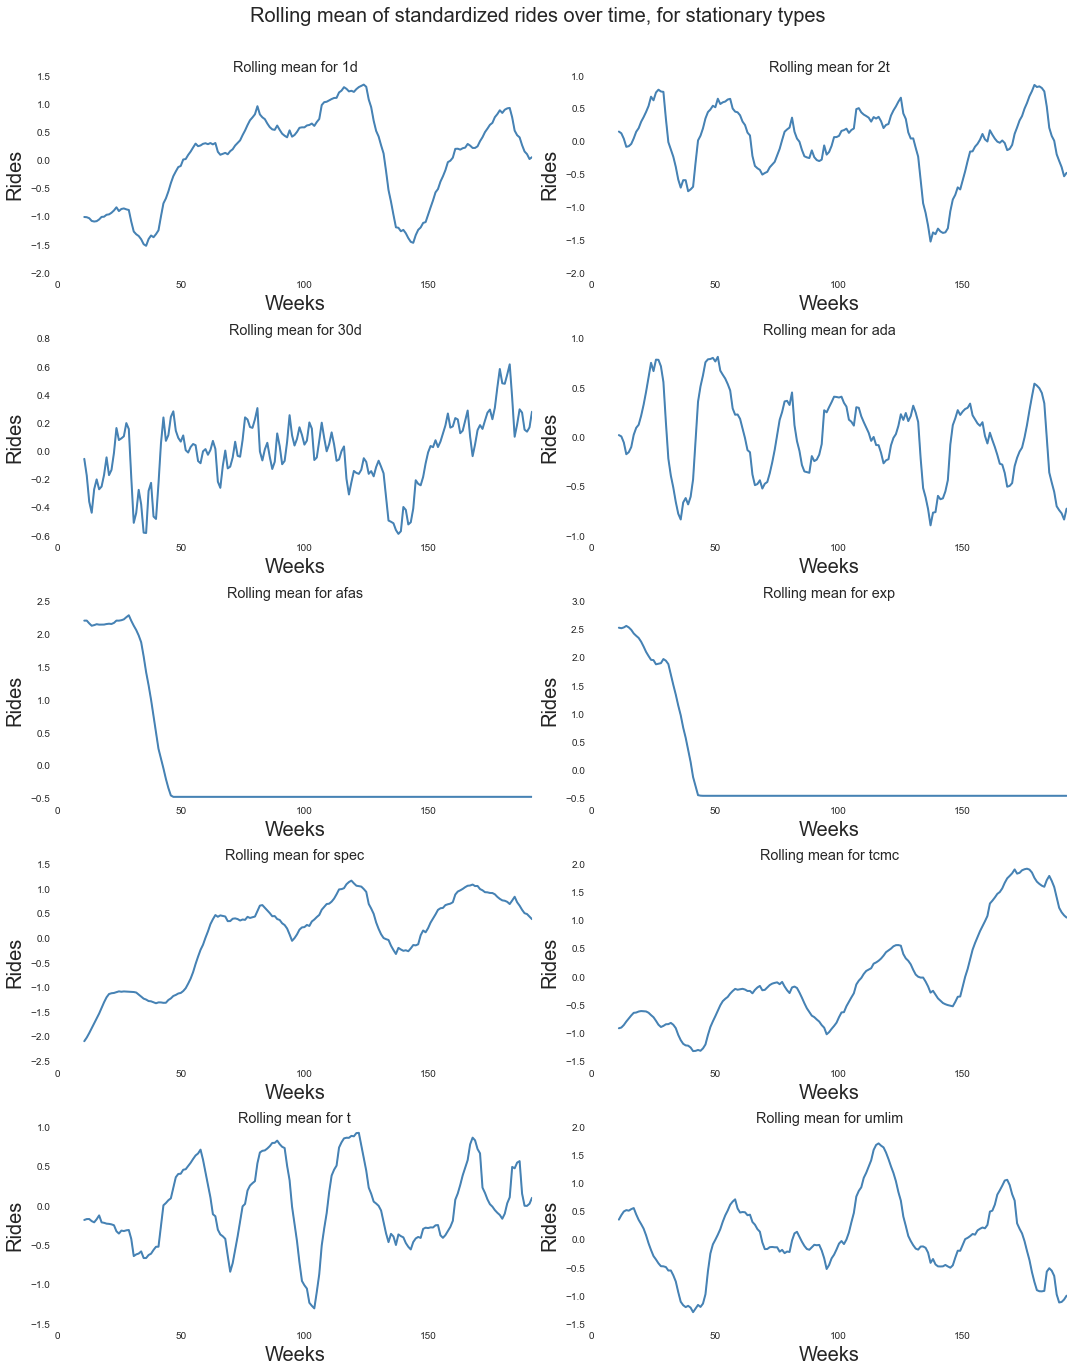

In [12]:
weekly_std = (weekly.loc[mask] - weekly.loc[mask].mean())/(weekly.loc[mask].std())

fig, axs = plt.subplots(5,2)
fig.set_size_inches(15,20)

rolling_std = pd.rolling_mean(weekly_std[ridetype], 12)

for i,rtype in enumerate(stationary):
    sns.tsplot(data=rolling_std[rtype], ax=axs[i/2,i%2])
    axs[i/2, i%2].set_title('Rolling mean for {}'.format(rtype))
    axs[i/2, i%2].set_xlabel("Weeks", fontsize=20)
    axs[i/2,i%2].set_ylabel("Rides", fontsize=20)

pl.suptitle('Rolling mean of standardized rides over time, for stationary types', fontsize=20)
pl.tight_layout(rect=[0, 0.03, 1, 0.95])

**Fig 3.** Time series of rolling mean over 12 weeks for the ride types defined stationary by the Augmented Dickey-Fuller test, from May 2010 to February 2014.

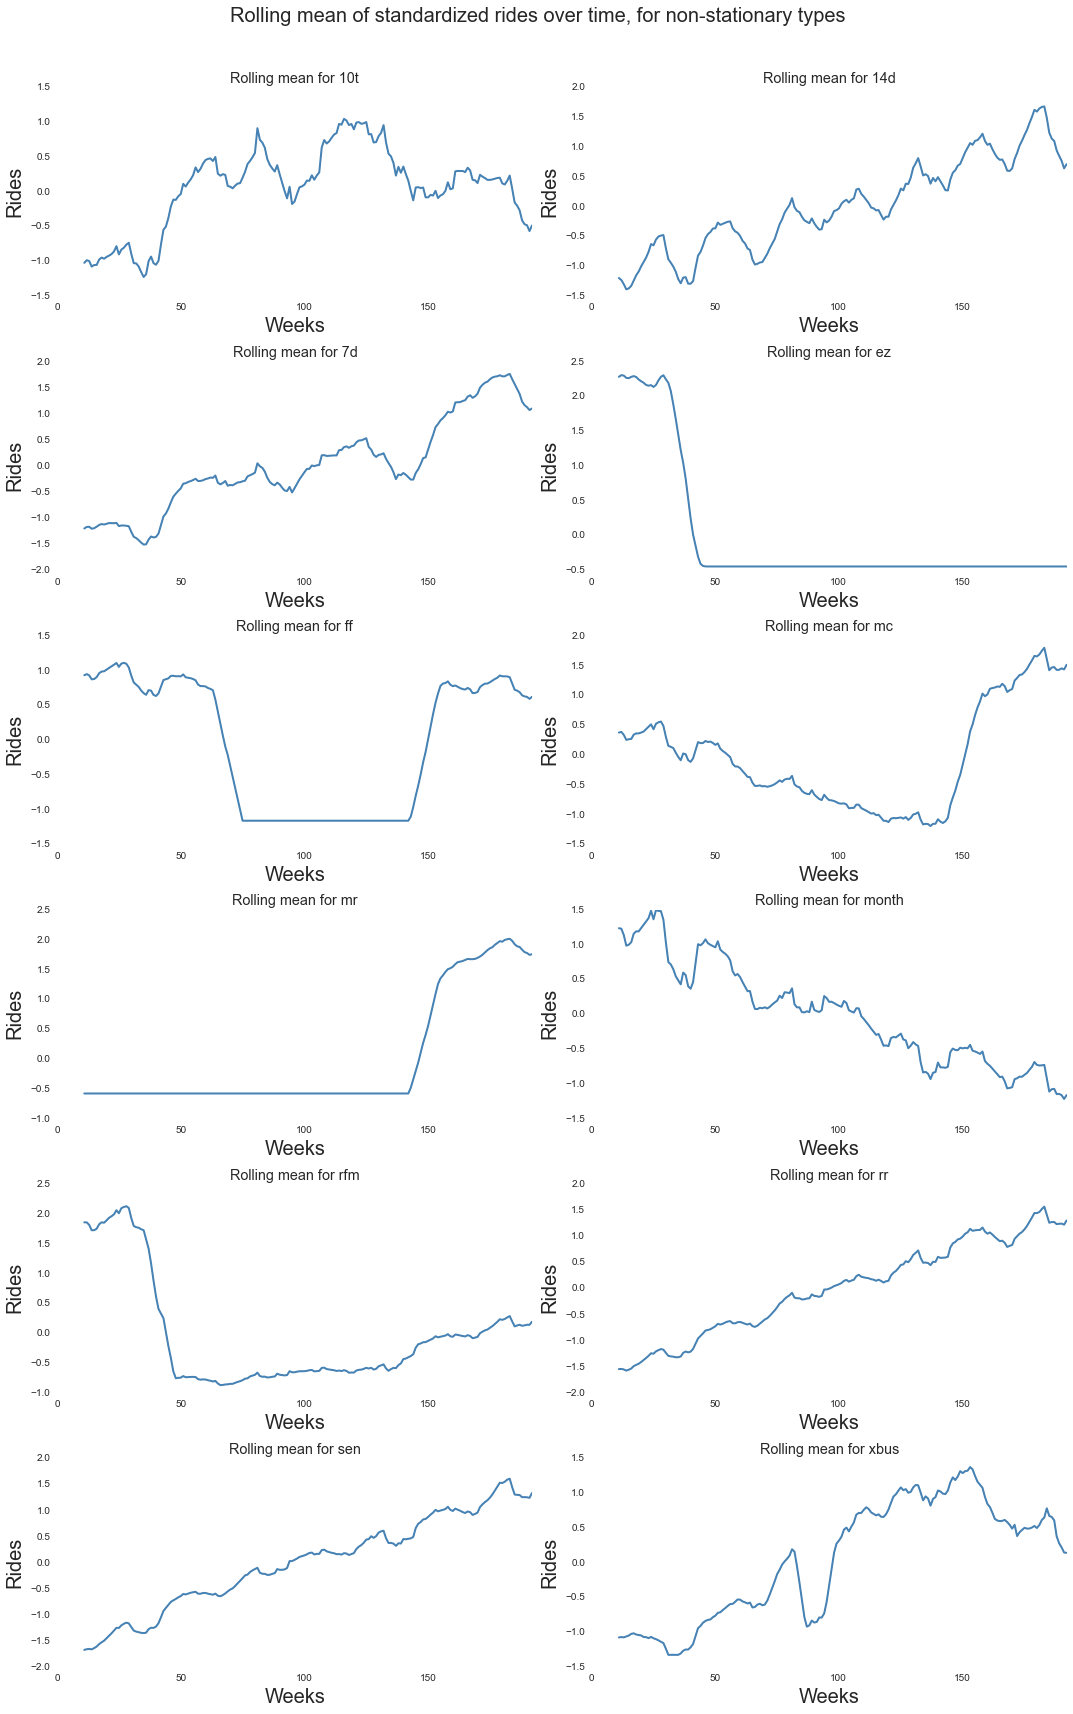

In [13]:
fig, axs = plt.subplots(6,2)
fig.set_size_inches(15,25)

for i,rtype in enumerate(nstationary):
    sns.tsplot(data=rolling_std[rtype], ax=axs[i/2,i%2])
    axs[i/2, i%2].set_title('Rolling mean for {}'.format(rtype))
    axs[i/2, i%2].set_xlabel("Weeks", fontsize=20)
    axs[i/2,i%2].set_ylabel("Rides", fontsize=20)
    
pl.suptitle('Rolling mean of standardized rides over time, for non-stationary types', fontsize=20)
pl.tight_layout(rect=[0, 0.03, 1, 0.95])

**Fig. 4** Time series of rolling mean over 12 weeks for rides defined non-stationary by the Augmented Dickey-Fuller test, from May 2010 to February 2014.

* The Express and 'AFAS' fares were determined stationary by the ADF test, but their rolling mean show rather a changing structure as their used was interrupted.
* Mail and Ride ('mr') was determined non stationary (and it is), but the ratio might be misleading as it was not used throughout the whole period.
* Full Fare ('ff') looks stationary, but was not deemed so as it was not used between 
* Finally, Reduced Fare Media ('rfm') experienced a structure change rather than a trend.

In [14]:
for rtype in nstationary:
    if rtype in ['ez', 'exp', 'afas']:
        print 'Type {0:} was not used anymore after {1:}'.format(rtype, 
                                                                 weekly.loc[mask & (weekly[rtype] == 0)].index[0])
    elif rtype == 'mr':
        print 'Type {0:} was used only after {1:}'.format(rtype, weekly.loc[mask & (weekly[rtype] == 0)].index[-1])
    elif rtype == 'ff':
        print 'Type {0:} was not used between {1:} and {2:}'.format(rtype, 
                                                                    weekly.loc[mask & (weekly[rtype] == 0)].index[0],
                                                                    weekly.loc[mask & (weekly[rtype] == 0)].index[-1])
    else:
        ratio = weekly[rtype][-10:].sum()/weekly[rtype][:10].sum()
        print 'Ratio for {0:} = {1:.2f}'.format(rtype, ratio)

Ratio for 10t = 1.02
Ratio for 14d = 1.25
Ratio for 7d = 1.39
Type ez was not used anymore after 2011-03-25 00:00:00
Type ff was not used between 2011-08-19 00:00:00 and 2013-02-15 00:00:00
Ratio for mc = 1.21
Type mr was used only after 2013-02-15 00:00:00
Ratio for month = 0.58
Ratio for rfm = 0.65
Ratio for rr = 2.59
Ratio for sen = 2.91
Ratio for xbus = 1.66


* The fare with the higher usage **increase** is the Senior and Disabled card, whose number of users nearly tripled.
* The fare with the higher usage **decrease** is the Monthly card, whose number of users was nearly cut in half.

#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

Largest periods: [ 193.    96.5]
Smallest periods: [ 2.05319149  2.03157895]


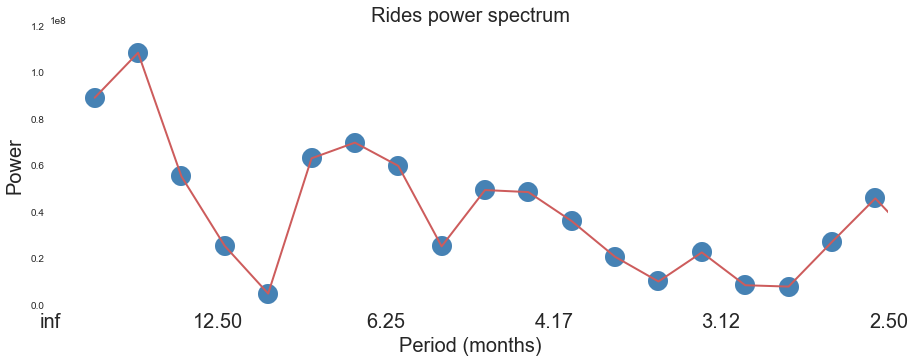

In [15]:
N = len(weekly.loc[mask])

print 'Largest periods:', 1.0/np.fft.rfftfreq(N, 1.0)[1:3]
print 'Smallest periods:', 1.0/np.fft.rfftfreq(N, 1.0)[-3:-1]

f = np.abs(np.fft.rfft(weekly.loc[mask, 'Total']))

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xlim(0,1.0/10)
ax.set_xticklabels([ "{0:.2f}".format(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (months)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Rides power spectrum", fontsize=20)

**Fig. 5** Power spectrum for the total rides time series. The spectrum presents, for each periodicity, how 'well' the associated periodic function fits the time series. The period fitting best the time series is the 24.125 period (roughly two years).

The 4th period (infinity aside) from the Fourier frequence list is 12.0625 months, which I will use as an approximation for the yearly period.

In [16]:
mask2 = panel.index != weekly.loc[weekly.Total < thresholds[1]].index[0]

In [17]:
fourier = {}
for i in panel.loc[mask2,'Station']:
    fourier[i] = np.abs(np.fft.rfft(panel.loc[mask2 & (panel.Station == i), 'Total']))[4]

In [18]:
fourier2 = pd.DataFrame.from_dict(fourier, orient='index').rename(columns={0: 'power'})
top = fourier2.sort_values('power', ascending=False)[:4].index.values

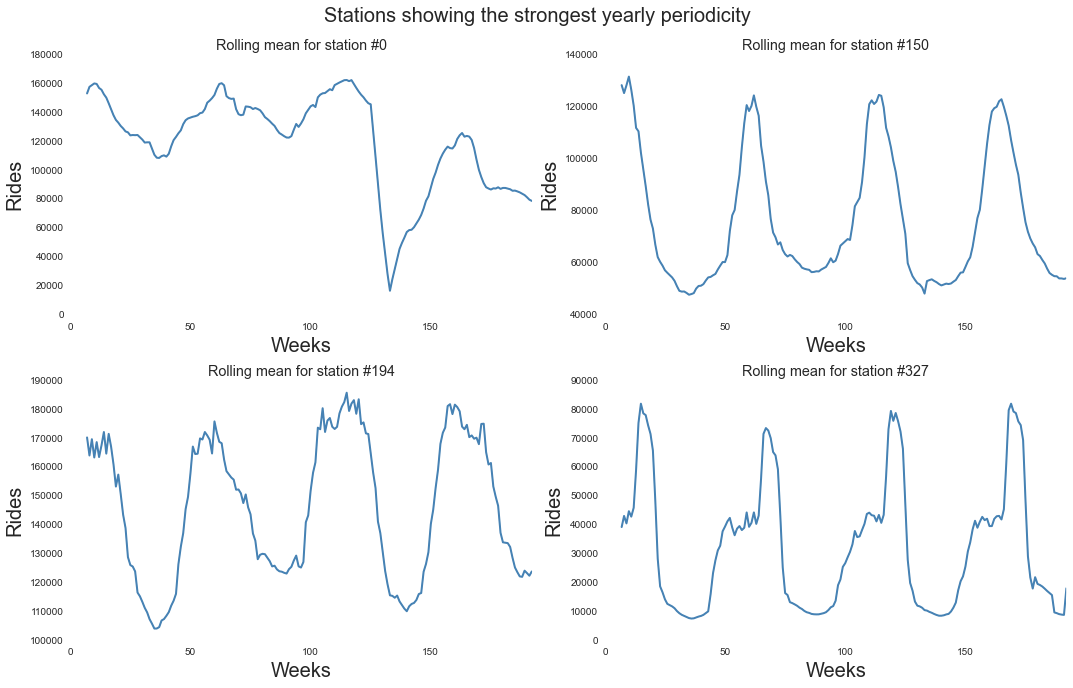

In [19]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(15,10)

#panel_rolling = pd.rolling_mean(panel.Total,15)

for i,station in enumerate(top):
    sns.tsplot(data=pd.rolling_mean(panel.loc[mask2 & (panel.Station == station), 'Total'],8), ax=axs[i/2,i%2])
    axs[i/2, i%2].set_title('Rolling mean for station #{}'.format(station))
    axs[i/2, i%2].set_xlabel("Weeks", fontsize=20)
    axs[i/2,i%2].set_ylabel("Rides", fontsize=20)
    
pl.suptitle('Stations showing the strongest yearly periodicity', fontsize=20)
pl.tight_layout(rect=[0, 0.03, 1, 0.95])

**Fig. 6** Time series of rolling mean over 8 weeks of total rides in the station showing the strongest yearly periodicity.

In [20]:
for station in top: 
    print 'Yearly periodic peak in station #{0:} on the: {1:}'.format(station,
                                                                     panel.loc[mask2 & (panel.Station == station), 
          'Total'].sort_values(ascending=False).index.map(lambda x: x.strftime('%Y-%m-%d'))[:4])

Yearly periodic peak in station #0 on the: ['2011-07-22' '2011-07-29' '2011-06-24' '2012-07-13']
Yearly periodic peak in station #150 on the: ['2010-06-25' '2012-06-22' '2011-06-24' '2010-06-11']
Yearly periodic peak in station #194 on the: ['2012-04-06' '2012-07-20' '2010-06-04' '2013-09-06']
Yearly periodic peak in station #327 on the: ['2013-08-09' '2010-08-27' '2013-08-16' '2012-08-24']


The peaks do not seem to be at any specific date (like 4th of July each year), but they all happen in Summer. So maybe that the day of the week will be more meaningful.

In [21]:
for station in top: 
    print 'Day of the periodic peak in station #{0:}: {1:}'.format(station,
                                                                     panel.loc[mask2 & (panel.Station == station),
                                                                               'Total'].sort_values(ascending=False).index.weekday[:4])

Day of the periodic peak in station #0: [4 4 4 4]
Day of the periodic peak in station #150: [4 4 4 4]
Day of the periodic peak in station #194: [4 4 4 4]
Day of the periodic peak in station #327: [4 4 4 4]


All yearly periodic peaks happened on the 4th day of the week, i.e on a Friday. So even without knowing where those stations are, we can assume that they are used by people leaving for (or returning from) holidays on fridays in the summer: stations close to Grand Central, Penn Station, JFK for the railway or the airport for instance.